In [1]:
!pwd

/afs/cern.ch/work/a/apoyet/bbcw2mad/examples


In [2]:
!which python

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/bin/python


# LHC Run 3 Using BBCW
---

This is an example on how to implement the wire compensators in the LHC Run 3 using the new MAD-X approach using Python. 

In [3]:
# %% Import few packages
from cpymad.madx import Madx
#import madxp
from madxp import cpymadTool as mt
from collections import OrderedDict
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from IPython.display import display
import time
import os
import warnings
warnings.filterwarnings('always')
from cl2pd import importData

#bbcw2mad package
from bbcw2mad.WireObj import *
from bbcw2mad.knob_wires import *

#phd-tools
from phd_toolbox import constants
from phd_toolbox import wires_tools


In [4]:
# %%
# ============================================================================================================ #
#                                              WORKFLOW FUNCTIONS                                              #
# ============================================================================================================ #

# %%

def make_sequence(mad, mylhcbeam, slicefactor, wires_lst=None):
    '''
    Function to build the machine sequence in MAD-X.
    
    Args: 
        mad: madx instance
        mylhcbeam: int, considered beam 
        slicefactor: int, determines in how many slices each element of the sequence will be sliced
        wires_lst: lst or None, if you want to install wires in the sequence, provide the list of 
                    the wanted wires (WireObj instances)
    '''
    start_time = time.time()
    mad.input('option, -echo,warn,-info;')
    mad.call('/afs/cern.ch/user/s/sterbini/public/tracking_tools/tools/macro.madx') 
    mad.call('tools/optics_indep_macros.madx')

    assert mylhcbeam in [1, 2, 4], "Invalid mylhcbeam (it should be in [1, 2, 4])"

    if mylhcbeam in [1, 2]:
        mad.call('/afs/cern.ch/eng/lhc/optics/runII/2018/lhc_as-built.seq')
    else:
        mad.call('/afs/cern.ch/eng/lhc/optics/runII/2018/lhcb4_as-built.seq')

    # New IR7 MQW layout and cabling
    mad.call('/afs/cern.ch/eng/lhc/optics/runIII/RunIII_dev/IR7-Run3seqedit.madx')
    
    # Makethin
    if slicefactor > 0:
        mad.input(f'slicefactor={slicefactor};') # the variable in the macro is slicefactor
        mad.call('/afs/cern.ch/eng/lhc/optics/runII/2018/toolkit/myslice.madx')
        mad.beam()
        for my_sequence in ['lhcb1','lhcb2']:
            if my_sequence in list(mad.sequence):
                mad.input(f'use, sequence={my_sequence}; makethin, sequence={my_sequence}, style=teapot, makedipedge=false;')
    else:
        warnings.warn('The sequences are not thin!')

    # Cycling w.r.t. to IP3 (mandatory to find closed orbit in collision in the presence of errors)
    for my_sequence in ['lhcb1','lhcb2']:
        if my_sequence in list(mad.sequence):
            mad.input(f'seqedit, sequence={my_sequence}; flatten; cycle, start=IP3; flatten; endedit;')
    
    # Install wires
    if wires_lst:
        for wire in wires_lst:
            wire.define_in_mad()
            wire.install_in_sequence()

    my_output_dict = get_status(mad)
    elapsed_time = time.time() - start_time
    my_output_dict['elapsed_time'] = elapsed_time
    return my_output_dict

def load_optics(mad, optics_number):
    start_time = time.time()
    mad.call(f'/afs/cern.ch/eng/lhc/optics/runIII/RunIII_dev/2021_V1/PROTON/opticsfile.{int(optics_number)}')
    my_output_dict = get_status(mad)
    elapsed_time = time.time() - start_time

    my_output_dict['elapsed_time'] = elapsed_time
    return my_output_dict

def get_status(mad):
    start_time = time.time()
    variables=mt.variables_dict(mad)
    my_output_dict= {'constant_df': variables['constant_df'],
            'independent_variable_df': variables['independent_variable_df'],
            'dependent_variable_df': variables['dependent_variable_df'],
            'sequences_df': mt.sequences_df(mad),
            'beams_df': mt.beams_df(mad),
            'tables_list': list(mad.table)}
    elapsed_time = time.time() - start_time
    my_output_dict['elapsed_time'] = elapsed_time
    return my_output_dict

def run_module(mad, module_name):
    start_time = time.time()
    mad.call(f'modules/{module_name}')
    elapsed_time = time.time() - start_time
    my_output_dict = get_status(mad)
    elapsed_time = time.time() - start_time
    my_output_dict['elapsed_time']= elapsed_time
    return my_output_dict

def read_parameters(mad, parameter_dict):
    start_time = time.time()
    parameter_dict['par_qx00']=int(parameter_dict['par_qx0'])
    parameter_dict['par_qy00']=int(parameter_dict['par_qy0'])
    parameter_dict['par_tsplit']=parameter_dict['par_qx00']-parameter_dict['par_qy00']
    assert parameter_dict['par_nco_IP5']==parameter_dict['par_nco_IP1']
    assert parameter_dict['par_qx00']-parameter_dict['par_qy00']==parameter_dict['par_tsplit']
    assert 'par_mylhcbeam' in parameter_dict
    assert 'par_beam_norm_emit' in parameter_dict
    for i in parameter_dict:
        mad.input(f'{i}={parameter_dict[i]};')
    my_output_dict = get_status(mad)
    elapsed_time = time.time() - start_time
    my_output_dict['elapsed_time']= elapsed_time
    return my_output_dict

def cleanall(file_string='fc.* *parquet twiss* log.madx stdout.madx bb_lenses.dat last_twiss.0.gz temp', rm_links=True):
    if rm_links:
        os.system('find -type l -delete')
    os.system('rm -rf '+ file_string)
    
def power_wires(mad,wires_lst,table_out):
    '''
    Function to turn on the wires as done in the LHC Run 3.
    
    Args:
        mad: madx instance
        wires_lst: list, contains the wires under the form of WireObj instances
        table_out: str, name of the madx table to be added to "twiss_" and "summary_" 
    Return: 
        my_output_dict: dict, contains the output info to be added to the working flow DF.
    '''
    start_time = time.time()
    
    # Turn off BB
    mad.input(f'''
    ON_BB_CHARGE=0;
    ''')

    for wire in wires_lst:
        wire.switch_wire(on=True)
        wire.print_lense()

    mad.input(f'''
    use, sequence=lhcb1;
    twiss, table=twiss_{table_out};
    exec, clonesumm('summary_{table_out}');
    ON_BB_CHARGE=1;
    ''')
    
    my_output_dict = get_status(mad)
    elapsed_time = time.time() - start_time

    my_output_dict['elapsed_time'] = elapsed_time
    return my_output_dict

In [5]:
# %%
# ============================================================================================================ #
#                                                PARAMETER DICT                                                #
# ============================================================================================================ #

parameter_dict={
    # =============================================================================
    # Beam parameters
    # =============================================================================
    ## LHC beam 1 (clockwise), LHC beam 2 (clockwise), LHC beam 2 (counterclockwise) 
    'par_mylhcbeam': 1, 
    ## beam normalized emittance [m rad]
    'par_beam_norm_emit': 2.5e-6,
    ## [m]
    'par_beam_sigt': 0.075,
    ## [-]           
    'par_beam_sige': 1.1e-4,
    ## [-]                    
    'par_beam_npart': 1.1e11, 
    ## [GeV]            
    'par_beam_energy_tot': 7000,
    ## [A]          
    'par_oct_current': 350,
    ## [-]            
    'par_chromaticity': 15,
    ## [MV]          
    'par_vrf_total': 16.,
    ## Tunes with fractional part          
    'par_qx0': 62.31, 'par_qy0': 60.32,
    # =============================================================================
    # Beam-Beam configuration 
    # =============================================================================
    ## install the BB elements [0,1]
    'par_on_bb_switch': 1,
    ## if 1 lumi leveling in ip8 is applied and q/q' match is done with bb off [0,1]
    'par_on_collision': 1, 
    ## bunch separation [ns]               
    'par_b_t_dist': 25.,   
    ## default value for the number of additionnal parasitic encounters inside D1              
    'par_n_inside_D1': 5,                 
    ## number of slices for head-on in IR1 [between 0 and 201]
    'par_nho_IR1': 11, 'par_nho_IR2': 11, 'par_nho_IR5': 11, 'par_nho_IR8': 11, 
    ## flag to install the Crab Cavities [0, 1]
    'par_install_crabcavities': 0,
    # =============================================================================
    # Beam-Beam Wire Compensators 
    # =============================================================================
    ## IR1
    'par_s_w_ir1': 19848.217400,              # s-position [m]
    'par_x_w_ir1': 0,                         # Horizontal transverse position of the wire, wrt to the beam [m]
    'par_y_w_ir1': 0.0091,                    # Vertical transverse position of the wire, wrt to the beam [m]
    'par_I_w_ir1': 350,                       # Wire Current [A]
    ## IR5
    'par_s_w_ir5': 6516.623433,   # s-position [m]
    'par_x_w_ir5': 0.01223,   # Horizontal transverse position of the wire, wrt to the beam [m]
    'par_y_w_ir5': 0,   # Vertical transverse position of the wire, wrt to the beam [m]
    'par_I_w_ir5': 350,   # Wire Current [A]
    # =============================================================================
    # Leveling in IP8   
    # =============================================================================
    # leveled luminosity in IP8 (considered if par_on_collision=1) [Hz/cm2]
    'par_lumi_ip8': 2e32,                 
    # These variables define the number of Head-On collisions in the 4 IPs
    'par_nco_IP1': 2544, 'par_nco_IP2': 2215, 'par_nco_IP5': 2544, 'par_nco_IP8': 2332,
    # =============================================================================
    # Errors and corrections 
    # =============================================================================
    # Select seed for errors
    'par_myseed': 0,
    # Set this flag to correct the errors of D2 in the NLC 
    # (warning: for now only correcting b3 of D2, still in development)
    'par_correct_for_D2': 0,
    # Set this flag to correct the errors of MCBXF in the NLC 
    # (warning: this might be less reproducable in reality, use with care)
    'par_correct_for_MCBX': 0,
    'par_off_all_errors': 0,
    'par_on_errors_LHC': 0,
    'par_on_errors_MBH': 0,
    'par_on_errors_Q5': 0,
    'par_on_errors_Q4': 0,
    'par_on_errors_D2': 0,
    'par_on_errors_D1': 0,
    'par_on_errors_IT': 0,
    'par_on_errors_MCBRD': 0,
    'par_on_errors_MCBXF': 0,
    # =============================================================================
    # Additional parameters
    # =============================================================================
    # parameter for having verbose output [0,1]
    'par_verbose': 1,
    # definition of the slicefactor used in the makethin
    'par_slicefactor': 4,
    # number of optics to use
    'par_optics_number':27,
    # Specify machine version
    'ver_lhc_run' : 3, 'ver_hllhc_optics' : 0,
}

In [6]:
#================================================================#
#                          MAD INSTANCE                          #
#================================================================#

# %%
command_log_file='log.madx'
stdout_file='stdout.madx'
with open(stdout_file, 'w') as myFile:
    mad = Madx(stdout=myFile,command_log=command_log_file)

working_folder='./'
os.chdir(working_folder)

In [7]:
#================================================================#
#                              BBCW                              #
#================================================================#

sequence_w = f'lhcb{parameter_dict["par_mylhcbeam"]}'
mad_inst_w = mad
# WIRE IR1
s_w_ir1 = parameter_dict['par_s_w_ir1']
x_w_ir1 = parameter_dict['par_x_w_ir1']
y_w_ir1 = parameter_dict['par_y_w_ir1']
I_w_ir1 = parameter_dict['par_I_w_ir1']
# WIRE IR5
s_w_ir5 = parameter_dict['par_s_w_ir5']
x_w_ir5 = parameter_dict['par_x_w_ir5']
y_w_ir5 = parameter_dict['par_y_w_ir5']
I_w_ir5 = parameter_dict['par_I_w_ir5']

# Define the wires 

bbcw_int_l1b1 = WireObj('bbcw_int_l1b1',I_w_ir1,s_w_ir1,x_w_ir1,y_w_ir1,parameter_dict['par_beam_npart'],mad_inst=mad_inst_w,sequence=sequence_w)
bbcw_ext_l1b1 = WireObj('bbcw_ext_l1b1',I_w_ir1,s_w_ir1,x_w_ir1,-y_w_ir1,parameter_dict['par_beam_npart'],mad_inst=mad_inst_w,sequence=sequence_w)

bbcw_int_l5b1 = WireObj('bbcw_int_l5b1',I_w_ir5,s_w_ir5,x_w_ir5,y_w_ir5,parameter_dict['par_beam_npart'],mad_inst=mad_inst_w,sequence=sequence_w)
bbcw_ext_l5b1 = WireObj('bbcw_ext_l5b1',I_w_ir5,s_w_ir5,-x_w_ir5,y_w_ir5,parameter_dict['par_beam_npart'],mad_inst=mad_inst_w,sequence=sequence_w)

wires_lst = [bbcw_int_l1b1, bbcw_ext_l1b1, bbcw_int_l5b1, bbcw_ext_l5b1]

# Describe the wires 
bbcw_int_l1b1.describe()
bbcw_ext_l1b1.describe()

{'current': 350,
 'mad_inst': <cpymad.madx.Madx object at 0x7fa3e16569e8>,
 'name': 'bbcw_int_l1b1',
 'nb': 110000000000.0,
 's_pos': 19848.2174,
 'sequence': 'lhcb1',
 'sigx': 0.0003333333333333333,
 'sigy': 0.0003333333333333333,
 'switch': 0,
 'x_co': 0,
 'x_pos': 0,
 'xma': 0,
 'y_co': 0,
 'y_pos': 0.0091,
 'yma': 0.0091}
{'current': 350,
 'mad_inst': <cpymad.madx.Madx object at 0x7fa3e16569e8>,
 'name': 'bbcw_ext_l1b1',
 'nb': 110000000000.0,
 's_pos': 19848.2174,
 'sequence': 'lhcb1',
 'sigx': 0.0003333333333333333,
 'sigy': 0.0003333333333333333,
 'switch': 0,
 'x_co': 0,
 'x_pos': 0,
 'xma': 0,
 'y_co': 0,
 'y_pos': -0.0091,
 'yma': -0.0091}


In [8]:
#================================================================#
#                              FLOW                              #
#================================================================#
#%% Make links for setting the enviroments
cleanall()
# Main path
os.system('ln -fns /afs/cern.ch/eng/tracking-tools tracking_tools')
# Mask code folder
os.system('ln -fns /afs/cern.ch/user/s/sterbini/public/tracking_tools/modules modules')
# Machine folder
os.system('ln -fns tracking_tools/machines machines')
# Toolkit folder
os.system('ln -fns tracking_tools/tools tools')
# Beam-beam macros folder
os.system('ln -fns tracking_tools/beambeam_macros beambeam_macros')
# Errors folder
os.system('ln -fns tracking_tools/errors errors')

0

In [9]:
#%% Start making MAD-X operation
my_workflow_dict = OrderedDict()

my_workflow_dict['read_parameters'] = read_parameters(mad, parameter_dict)
my_workflow_dict['make_sequence'] = make_sequence(mad, parameter_dict['par_mylhcbeam'], parameter_dict['par_slicefactor'],wires_lst=wires_lst)
my_workflow_dict['load_optics'] = load_optics(mad, parameter_dict['par_optics_number'])
my_workflow_dict['check_optics'] = run_module(mad,'module_00_check_optics.madx')

execution_df=pd.DataFrame(my_workflow_dict).transpose()

In [10]:
# Define the knobs for wire matching
knobs_run3 = knob_wires(mad_inst=mad)
knobs_run3.define_q4_ir1_knob(wire_ir1=bbcw_int_l1b1)
knobs_run3.define_q4_ir5_knob(wire_ir5=bbcw_int_l5b1)

In [11]:
# %%
def from_beta_to_xing_angle_urad(beta_m):
    return  0.5*(132.47 + 58.3959 * np.sqrt(beta_m) + 30.0211 * beta_m)/np.sqrt(beta_m)

knob_dict={
    'on_sep1': 0,  
    'on_sep5': 0,         
    'on_sep2h': 1,
    'on_sep2v': 0,
    'on_x2h': 0,
    'on_x2v': 200,
    'on_sep8h': 0,
    'on_sep8v': 1,
    'on_x8h': 0,
    'on_x8v': 135,
    'on_disp': 1,
    'on_alice': 7000/parameter_dict['par_beam_energy_tot'],
    'on_lhcb': 7000/parameter_dict['par_beam_energy_tot'],
    'on_sol_atlas': 7000/parameter_dict['par_beam_energy_tot'],
    'on_sol_cms': 7000/parameter_dict['par_beam_energy_tot'],
    'on_sol_alice': 7000/parameter_dict['par_beam_energy_tot'],
}
betx_ip1 = mad.globals['betx_ip1']
knob_dict['on_x1'] = from_beta_to_xing_angle_urad(betx_ip1)
knob_dict['on_x5'] = from_beta_to_xing_angle_urad(betx_ip1)

for i in knob_dict:
    mad.input(f'{i} = {knob_dict[i]};')

mad.input('on_sep8=on_sep8v;')
mad.input('on_sep2=on_sep2h;')

my_workflow_dict['save_crossing'] = run_module(mad,'module_01_save_crossing.madx')
execution_df=pd.DataFrame(my_workflow_dict).transpose()

In [12]:
# %% Running the leveling and the beam-beam
my_workflow_dict['lumilevel'] = run_module(mad,'module_02_lumilevel.madx')

mad.input('on_sep8v=on_sep8;')
mad.input('on_sep2h=on_sep2;')

my_workflow_dict['beambeam'] = run_module(mad,'module_03_beambeam.madx')
execution_df=pd.DataFrame(my_workflow_dict).transpose()

In [13]:
# %% From Sofia: check the luminosity
summary = {}
twiss = {}
beams = {}
for beam in [1,2]:
    summary[f'B{beam}'] = mt.summ_df(mad.table[f'summary_beambeam_b{beam}'])
    twiss[f'B{beam}'] = mt.table_df(mad.table[f'twiss_beambeam_b{beam}'])
    beams[f'B{beam}'] = mt.beams_df(mad).loc[[f'lhcb{beam}']]

def cmp_luminosity_0(intensity, bunches, sigma_X, sigma_P, frev=11245.5):
    return (intensity**2*bunches*frev)/(4.0*np.pi*sigma_X*sigma_P)

def crossing_factor(phi, sigmaz, sigma_X):
    return 1./np.sqrt(1. + (sigmaz*phi/2.)**2/(sigma_X**2)  )

def offset_factor(halo):
    a  = -(halo/ 2.)**2
    return np.exp(a)

def cmp_luminosity(intensity, bunches, sigma_X, sigma_P, phi, sigmaz, halo,frev=11245.5):
    crossing = crossing_factor(phi, sigmaz, sigma_X)
    offset   = offset_factor(halo)
    return cmp_luminosity_0(intensity, bunches, sigma_X, sigma_P, frev)*crossing*offset

def luminous_region(phi, sigmaz, sigma_X):
    return sigmaz/np.sqrt(2.)*crossing_factor(phi, sigmaz, sigma_X)

for beam in [1, 2]:
    print("Beam %s" %beam)
    for nIP in [1,2,5,8]:
        intensity    = beams[f'B{beam}']['npart'].values[0]
        bunch_length = beams[f'B{beam}']['sigt'].values[0]
        egeom_x      = beams[f'B{beam}']['ex'].values[0]
        egeom_y      = beams[f'B{beam}']['ey'].values[0]

        bunches   = mad.globals.get('nco_IP%s' %nIP)
        beta_x    = twiss[f'B{beam}'].loc[f'ip{nIP}:1']['betx']
        beta_y    = twiss[f'B{beam}'].loc[f'ip{nIP}:1']['bety']
        sigma_x   = np.sqrt(egeom_x*beta_x)
        sigma_y   = np.sqrt(egeom_y*beta_y)

        offlvl_px = twiss[f'B{beam}'].loc[f'ip{nIP}:1']['px']
        offlvl_py = twiss[f'B{beam}'].loc[f'ip{nIP}:1']['py']

        offlvl_x_b1  = twiss['B1'].loc[f'ip{nIP}:1']['x']
        offlvl_y_b1  = twiss['B1'].loc[f'ip{nIP}:1']['y']
        offlvl_x_b2  = twiss['B2'].loc[f'ip{nIP}:1']['x']
        offlvl_y_b2  = twiss['B2'].loc[f'ip{nIP}:1']['y']

        if abs(offlvl_px)>abs(offlvl_py):
            #print('Vertical crossing')   
            phi        = 2.0*offlvl_px
            sigma_Xing = sigma_x
            sigma_Par  = sigma_y
            halo =  abs(offlvl_x_b1-offlvl_x_b2)/sigma_x

        else:
            #print('Vertical crossing')   
            phi        = 2.0*offlvl_py
            sigma_Xing = sigma_y
            sigma_Par  = sigma_x
            halo =  abs(offlvl_y_b1-offlvl_y_b2)/sigma_y


        print('Luminosity in IP%s: %s Hz/cm^2'%(nIP, cmp_luminosity(intensity, bunches, sigma_Xing, sigma_Par, phi, bunch_length, halo)*1e-4))

Beam 1
Luminosity in IP1: 1.7678745157699802e+34 Hz/cm^2
Luminosity in IP2: 6.752050987283468e+32 Hz/cm^2
Luminosity in IP5: 1.7677105304097287e+34 Hz/cm^2
Luminosity in IP8: 1.9834627965161303e+32 Hz/cm^2
Beam 2
Luminosity in IP1: 1.7668844914712952e+34 Hz/cm^2
Luminosity in IP2: 6.757965615117597e+32 Hz/cm^2
Luminosity in IP5: 1.7676085223768612e+34 Hz/cm^2
Luminosity in IP8: 1.9873441215455716e+32 Hz/cm^2


In [14]:
# %% Machine tuning and last twiss
my_sequence_df=mt.sequence_df(mad, 'lhcb1')

assert mad.globals['mylhcbeam'] == 1

assert len(mt.knob_df('dqx.b1_sq',my_sequence_df)) > 0
assert len(mt.knob_df('kqtf',my_sequence_df)) == 0

assert len(mt.knob_df('vrf400',my_sequence_df)) > 0

assert mad.globals['dqx.b1_sq'] == 0
assert mad.globals['dqy.b1_sq'] == 0
assert mad.globals['dqx.b2_sq'] == 0
assert mad.globals['dqy.b2_sq'] == 0

mad.input('dqx.b1_sq := kqtf;')
mad.input('dqy.b1_sq := kqtd;')

assert mad.globals['dqpx.b1_sq'] == 0
assert mad.globals['dqpy.b1_sq'] == 0
assert mad.globals['dqpx.b2_sq'] == 0
assert mad.globals['dqpy.b2_sq'] == 0

mad.input('dqpx.b1_sq := ksf;')
mad.input('dqpy.b1_sq := ksd;')

my_workflow_dict['machine_tuning'] = run_module(mad,'module_05_machine_tuning.madx')


In [15]:
# Update wire position
for wire in wires_lst:
    wire.get_closed_orbit(table_input='twiss_after_machine_tuning')

my_workflow_dict['turn_on_wires'] = power_wires(mad,wires_lst,table_out='b1_wires')
my_workflow_dict['make_sixtrack_input'] = run_module(mad,'module_06_make_sixtrack_input.madx')
my_workflow_dict['last_twiss.madx'] = run_module(mad,'module_07_last_twiss.madx')

execution_df=pd.DataFrame(my_workflow_dict).transpose()

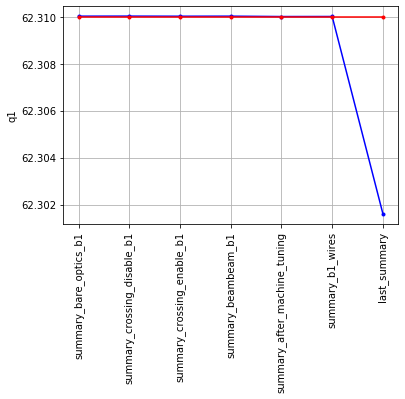

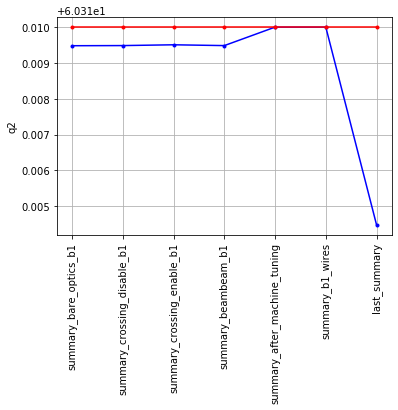

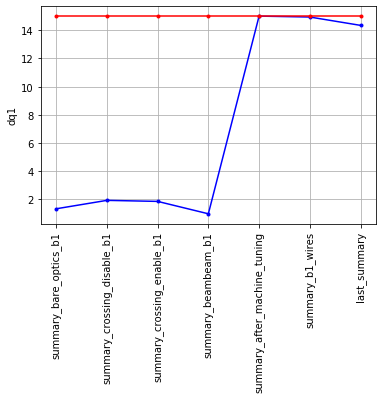

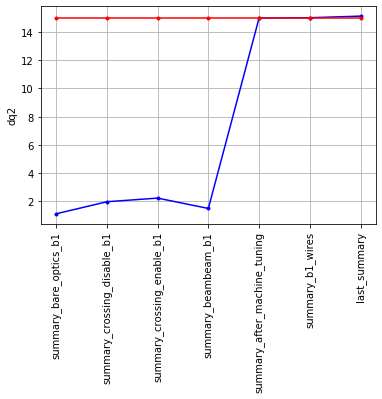

In [16]:
# %%
summary_df = pd.DataFrame()
for my_summary in ['summary_bare_optics_b1',
                  'summary_crossing_disable_b1',
                  'summary_crossing_enable_b1',
                  'summary_beambeam_b1',
                  'summary_after_machine_tuning',
                  'summary_b1_wires',
                  'last_summary']:
    summary_df = pd.concat([summary_df, mt.summ_df(mad.table[my_summary])])

summary_df['par_qx0']=parameter_dict['par_qx0']
summary_df['par_qy0']=parameter_dict['par_qy0']
summary_df['par_chromaticity']=parameter_dict['par_chromaticity']


for my_quantity, my_parameter in zip(['q1','q2','dq1','dq2'],
                                     ['par_qx0','par_qy0','par_chromaticity','par_chromaticity']):
    plt.figure()
    plt.plot(summary_df[my_quantity],'.-b')
    plt.plot(summary_df[my_parameter],'.-r')

    plt.xticks(rotation=90)
    plt.ylabel(my_quantity)
    plt.grid(True)

In [17]:
mad.table.summary_b1_wires['q1']

array([62.31000222])